# Schedule-Adjusted League Table

## Actual League Table

Idea from : [StastBomb Blog Post](https://statsbomb.com/2018/11/introducing-the-schedule-adjusted-league-table/)

In [1]:
import pandas as pd
import numpy as np

In [2]:
fixtures = pd.read_csv('../data/fpl_official/vaastav/data/2021-22/fixtures.csv')

results = fixtures[fixtures['finished'] == True][['team_a', 'team_a_score', 'team_h', 'team_h_score']]

In [3]:
league_table = pd.read_csv('../data/fpl_official/vaastav/data/2021-22/teams.csv')[['id', 'name', 'short_name']]
league_table['points'] = 0

In [4]:
def score_to_points_at_home(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] < row['team_h_score']:
        return 3
    else:
        return 0

home_results = results.copy()
home_results['points'] = home_results.apply(lambda row: score_to_points_at_home(row), axis=1)
home_results = (home_results.loc[:, ['team_a', 'team_h', 'points']])

In [5]:
def score_to_points_at_away(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] > row['team_h_score']:
        return 3
    else:
        return 0

away_results = results.copy()
away_results['points'] = away_results.apply(lambda row: score_to_points_at_away(row), axis=1)
away_results = (away_results.loc[:, ['team_a', 'team_h', 'points']])

In [6]:
def aggregate_points(team):
    return home_results[home_results['team_h'] == team]['points'].sum() +\
           away_results[away_results['team_a'] == team]['points'].sum()

In [7]:
lt = (league_table.id.map(aggregate_points))
league_table['points'] = lt
league_table.sort_values(by=['points'], ascending=False)

,id,name,short_name,points
10,11,Liverpool,LIV,10
5,6,Chelsea,CHE,10
7,8,Everton,EVE,10
12,13,Man Utd,MUN,10
3,4,Brighton,BHA,9
11,12,Man City,MCI,9
16,17,Spurs,TOT,9
18,19,West Ham,WHU,8
8,9,Leicester,LEI,6
2,3,Brentford,BRE,5


## SALT

In [8]:
from itertools import combinations

In [9]:
def home_points(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] < row['team_h_score']:
        return 3
    else:
        return 0

home_results = results.copy()
home_results['points'] = home_results.apply(lambda row: home_points(row), axis=1)
home_results = (home_results
               .assign(venue = 'home')
               .rename(columns = {
                   'team_h': 'team',
                   'team_a': 'opponent'
               })
               .loc[:, ['team', 'opponent', 'venue', 'points']])

In [10]:
def away_points(row):
    if row['team_a_score'] == row['team_h_score']:
        return 1
    elif row['team_a_score'] > row['team_h_score']:
        return 3
    else:
        return 0

away_results = results.copy()
away_results['points'] = away_results.apply(lambda row: away_points(row), axis=1)
away_results = (away_results
               .assign(venue = 'away')
               .rename(columns = {
                   'team_a': 'team',
                   'team_h': 'opponent'
               })
               .loc[:, ['team', 'opponent', 'venue', 'points']])

In [11]:
all_results = pd.concat([home_results, away_results], ignore_index=True)
all_results.head()

,team,opponent,venue,points
0,3,1,home,3
1,13,10,home,3
2,5,4,home,0
3,6,7,home,3
4,8,16,home,3


In [12]:
w = pd.DataFrame(index=list(combinations(league_table["id"], 2)),
                             columns=league_table["id"]).fillna(0)

for idx, row in w.iterrows():
    w.loc[[idx], idx[0]] = 1
    w.loc[[idx], idx[1]] = -1

W = w.values

array([[ 1, -1,  0, ...,  0,  0,  0],
       [ 1,  0, -1, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1, -1,  0],
       [ 0,  0,  0, ...,  1,  0, -1],
       [ 0,  0,  0, ...,  0,  1, -1]])

In [21]:
def points_per_game_difference(teams):
    same_fixture = (
        all_results[all_results.team == teams[0]]
        .merge(all_results[all_results.team == teams[1]],
            how='inner',
            on=['opponent','venue']))

    if not same_fixture.empty:
        ppg_difference = (
            (same_fixture.points_x.sum() -
            same_fixture.points_y.sum())
            / same_fixture.shape[0]
            )
    else:
        ppg_difference = 0
    
    return ppg_difference

In [22]:
r = w.index.map(points_per_game_difference).values.reshape(w.shape[0], 1)

In [23]:
# Solve Wx = r using Least Squared Error
x = np.linalg.lstsq(W, r, rcond=None)[0]

In [24]:
sorted(zip(league_table['name'], x), key=lambda x: x[1], reverse=True)

[('Chelsea', array([0.3])),
 ('Crystal Palace', array([0.2])),
 ('Everton', array([0.2])),
 ('Brighton', array([0.175])),
 ('Man City', array([0.15])),
 ('West Ham', array([0.15])),
 ('Liverpool', array([0.1])),
 ('Man Utd', array([0.1])),
 ('Spurs', array([0.1])),
 ('Brentford', array([0.1])),
 ('Southampton', array([-4.8143169e-17])),
 ('Leeds', array([-0.025])),
 ('Leicester', array([-0.05])),
 ('Aston Villa', array([-0.15])),
 ('Burnley', array([-0.15])),
 ('Newcastle', array([-0.2])),
 ('Wolves', array([-0.2])),
 ('Arsenal', array([-0.2])),
 ('Norwich', array([-0.3])),
 ('Watford', array([-0.3]))]

In [26]:
mapping_table = pd.DataFrame(index=list(combinations(league_table["name"], 2)),
                             columns=league_table["name"]).fillna(0)

m = (all_results
     .groupby('team')
     .points
     .count()
     .values
     .reshape(len(mapping_table.columns), 1))

In [27]:
adjusted_points = m * (x + all_results.points.mean())

In [35]:
league_table['adj_points'] = adjusted_points
league_table.sort_values(by=['points'], ascending=False).drop(["id"], axis=1)

,name,short_name,points,adjusted points,adj_points
10,Liverpool,LIV,10,5.95,5.95
5,Chelsea,CHE,10,6.75,6.75
7,Everton,EVE,10,6.35,6.35
12,Man Utd,MUN,10,5.95,5.95
3,Brighton,BHA,9,6.25,6.25
11,Man City,MCI,9,6.15,6.15
16,Spurs,TOT,9,5.95,5.95
18,West Ham,WHU,8,6.15,6.15
8,Leicester,LEI,6,5.35,5.35
2,Brentford,BRE,5,5.95,5.95


In [32]:
colors = {
    # https://teamcolorcodes.com/soccer/premier-league-color-codes/
    'ARS': '#EF0107',
    'AVL': '#95bfe5',
    'BHA': '#0057B8',
    'BRE': '#DA291C',
    'BUR': '#6C1D45',
    'CHE': '#034694',
    'CRY': '#1B458F',
    'EVE': '#003399',
    'LEI': '#003090',
    'LEE': '#FFCD00',
    'LIV': '#c8102E',
    'MCI': '#6CABDD',
    'MUN': '#DA291C',
    'NOR': '#FFF200',
    'NEW': '#241F20',
    'SOU': '#d71920',
    'TOT': '#132257',
    'WAT': '#FBEE23',
    'WHU': '#7A263A',
    'WOL': '#FDB913'
}

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

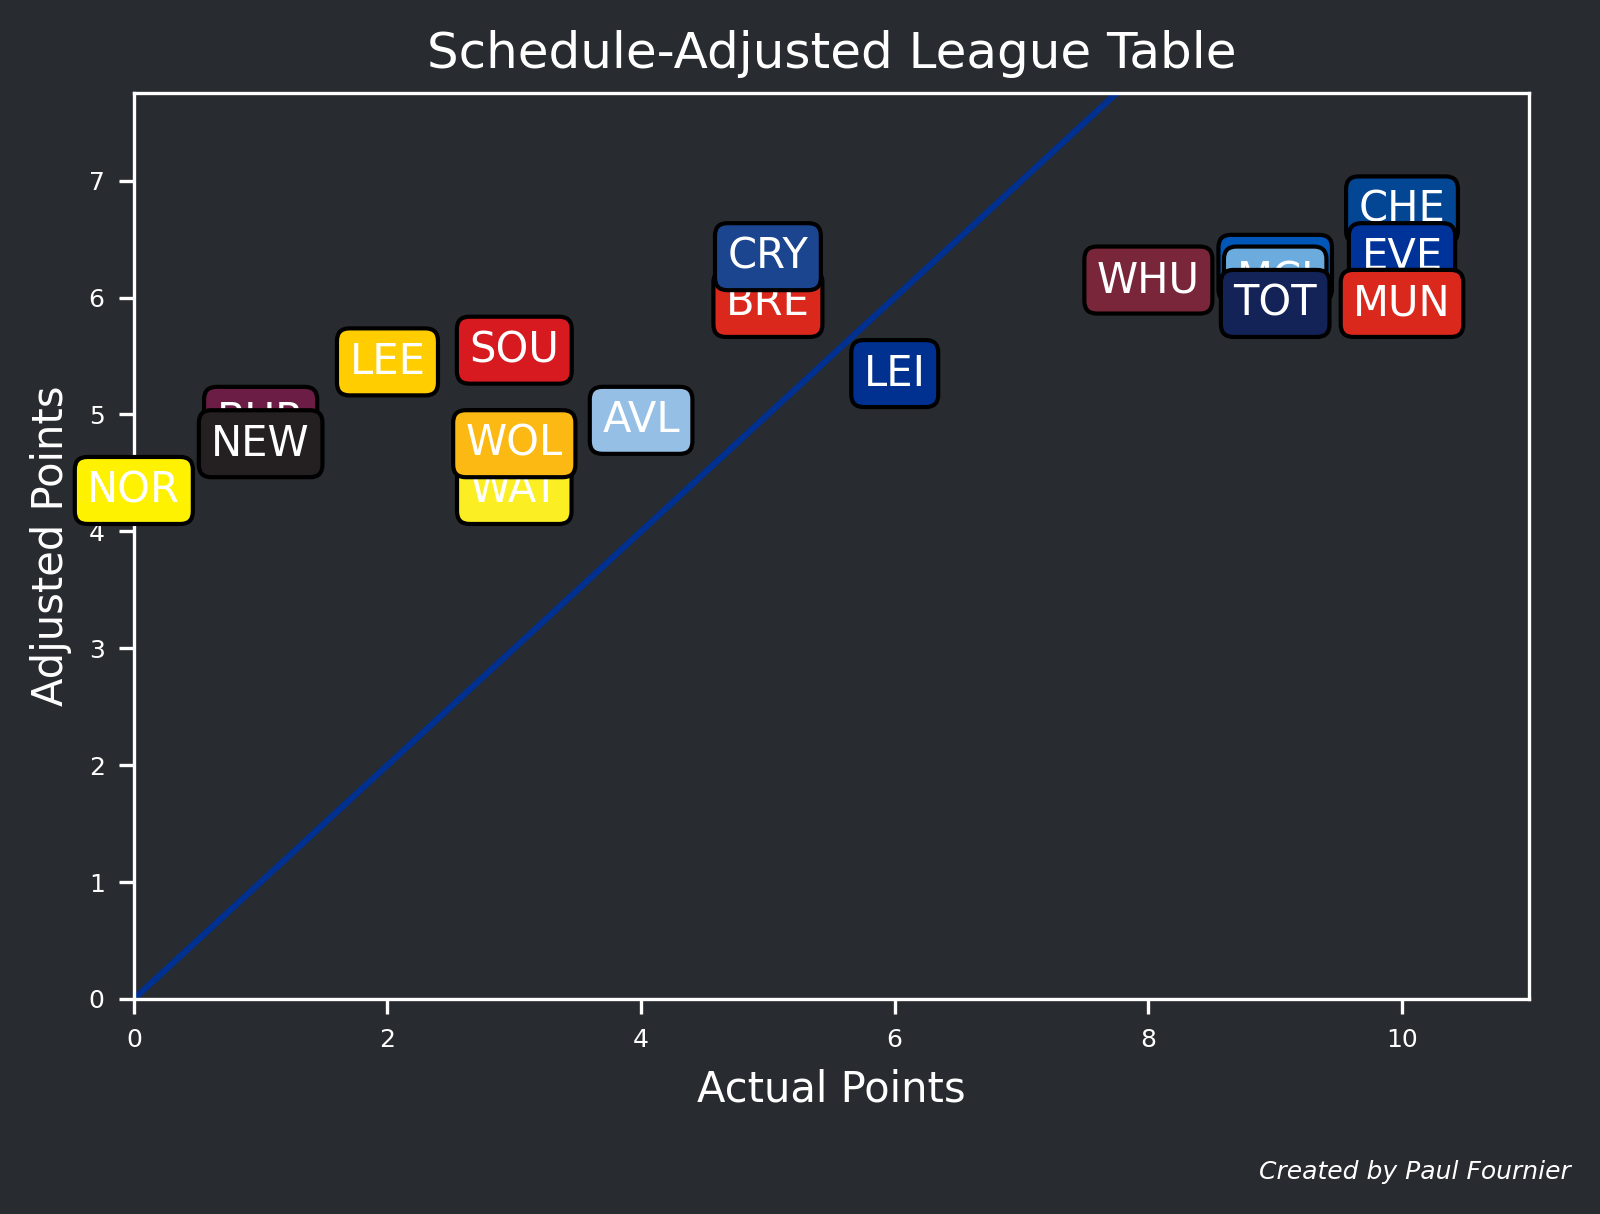

In [50]:
fig, ax = plt.subplots()
fig.set_facecolor(background)
ax.patch.set_alpha(0)

max_1 = league_table["adj_points"].max()
max_2 = league_table["points"].max()
ax.set(xlim=(0, max_2+1), ylim=(0, max_1+1))

ax.set_xlabel('Actual Points')
ax.set_ylabel('Adjusted Points')
ax.xaxis.label.set_color(text_color)
ax.yaxis.label.set_color(text_color)

plt.title(f'Schedule-Adjusted League Table')

ref_line = [0.0, max(max_1, max_2)+1]
ax.plot(ref_line, ref_line, color='#003090')

for idx, row in league_table.iterrows():
    ax.annotate(row.values[2],
                xy=(row["points"], row["adj_points"]),
                xycoords='data',
                bbox=dict(boxstyle='round', fc=(colors[row.values[2]])),
                ha='center',
                va='center',
                color='white')

fig.text(
    0.75, -0.025, "Created by Paul Fournier",
    fontstyle="italic", fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()